In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
from robot import computeRobotData, drawRobotArm, plotRobotDistribution, computeY



#tf.enable_eager_execution()
root_logdir = "./tf_logs"

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/janine/anaconda3/envs/GANProject/bin/python


'1.13.1'

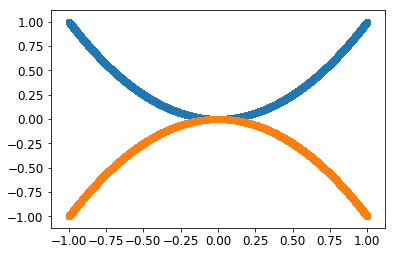

In [2]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.float32(np.array(data1)), np.float32(np.array(data2))

nSamples = 20000
X1, X2 = sample_data(n=nSamples,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

(20000, 2)
(20000, 2)
(20000, 2)
(20000, 10)
(20000, 10)
2
1
0


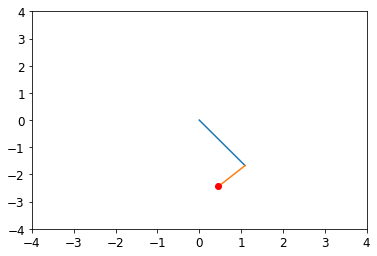

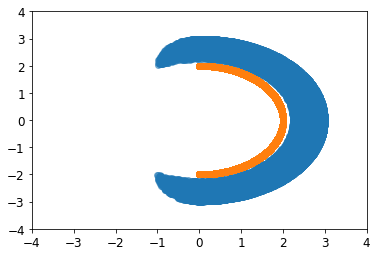

In [3]:
nrLinks1 = 2
lengths1 = [2,1]
nrLinks2 = 2
lengths2 = [2,0.8]
nrSamples = 20000
xr1, yr1 = computeRobotData([-np.pi/2, np.pi/2], nrLinks1, lengths1, nrSamples)
xr1Test, yr1Test = computeRobotData([-np.pi/2, np.pi/2], 2, [2,1], nrSamples)
xr2, yr2 = computeRobotData([-np.pi/2, np.pi/2], nrLinks2, lengths2, nrSamples)
r1=np.concatenate([xr1,yr1], axis=1)
r2=np.concatenate([xr2,yr2], axis=1)
print(r1.shape)
print(r2.shape)
drawRobotArm(yr1[1,:4])
plt.figure()
plotRobotDistribution(yr1[:,:4])
train_data = np.concatenate([r1,r2], axis=1)

In [4]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

#nDimX = X1.shape[1]
#nDimY = X2.shape[1]
nDimX = r1.shape[1]
nDimY = r2.shape[1]

GAN = RoboGAN(nDimX, nDimY)

G = GAN.G
D_Y = GAN.D_Y
F = GAN.F
D_X = GAN.D_X

# Getting placeholders
X = GAN.X
Y = GAN.Y

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
from train import train_step

losses, gradients, trainers, summary_op = train_step(GAN)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# Unpacking losses and gradients from training step output
G_loss, F_loss, D_Y_loss, D_X_loss = losses
G_gradients, F_gradients, D_Y_gradients, D_X_gradients = gradients
train_G, train_F, train_D_Y, train_D_X = trainers

## Running the training via a tensorflow session
> Generators will be trained first

In [ ]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

# Delete exisiting events file
for file in os.listdir(root_logdir):
    os.remove(root_logdir+"/"+file)

train_writer = tf.summary.FileWriter(root_logdir, tf.get_default_graph())

start_time = time.time()
batch_size = 100
n_batches = nSamples / batch_size

for epoch in range(100):
    for batch_index, batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:nDimX]
        Y_batch = batch[:,nDimX:]
        
        
        # Training Generators G and F first w/ cycle consistency
        Gloss, Floss, _,_ = sess.run([G_loss, F_loss, train_G, train_F],
                                     feed_dict={X:X_batch, Y:Y_batch})
        
        # Optimizing Discriminators D_X and D_Y
        D_Xloss, D_Yloss, _,_, summary = sess.run([D_X_loss, D_Y_loss, train_D_X, train_D_Y, summary_op],
                                         feed_dict={X: X_batch, Y: Y_batch})
        
        step = epoch * n_batches + batch_index 
        if step % 100 == 0:
            train_writer.add_summary(summary, step)
#         train_writer.flush()
    
    print("Epoch {}: GLoss:{:.4f}, FLoss:{:.4f}, DXLoss:{:.4f}, DYLoss:{:.4f}".format(epoch,Gloss,Floss,D_Xloss,D_Yloss))

print("Runtime: {:.3f}s".format(time.time()-start_time))
train_writer.close()

Epoch 0: GLoss:5.0637, FLoss:5.1779, DXLoss:0.4249, DYLoss:0.4370
Epoch 1: GLoss:3.4883, FLoss:3.7532, DXLoss:0.3750, DYLoss:0.5191
Epoch 2: GLoss:2.9017, FLoss:2.9833, DXLoss:0.5783, DYLoss:0.6156
Epoch 3: GLoss:2.6357, FLoss:2.6319, DXLoss:0.5360, DYLoss:0.5326
Epoch 4: GLoss:2.3958, FLoss:2.4582, DXLoss:0.5425, DYLoss:0.5518
Epoch 5: GLoss:2.2875, FLoss:2.3502, DXLoss:0.5685, DYLoss:0.5681
Epoch 6: GLoss:2.1694, FLoss:2.2072, DXLoss:0.5642, DYLoss:0.5930
Epoch 7: GLoss:2.1373, FLoss:2.1904, DXLoss:0.5546, DYLoss:0.6167
Epoch 8: GLoss:1.8999, FLoss:1.9695, DXLoss:0.5437, DYLoss:0.5967
Epoch 9: GLoss:1.9056, FLoss:1.9237, DXLoss:0.5446, DYLoss:0.5761
Epoch 10: GLoss:1.8125, FLoss:1.8123, DXLoss:0.5602, DYLoss:0.5729
Epoch 11: GLoss:1.9104, FLoss:1.8538, DXLoss:0.5304, DYLoss:0.5558
Epoch 12: GLoss:1.8211, FLoss:1.8730, DXLoss:0.5364, DYLoss:0.5614
Epoch 13: GLoss:1.8660, FLoss:1.8304, DXLoss:0.5553, DYLoss:0.5585


In [ ]:
test_data1 = np.concatenate([xr1Test,yr1Test], axis=1)
#test_data1 = np.concatenate([xr2Test,yr2Test], axis=1)
generated=sess.run([G(X)], feed_dict={X: test_data1[:20000]})
generated = generated[0]

def endEffectorDist(set1, set2):
    
    endeff1 = set1[:,nrLinks1*4-2:nrLinks1*4]
    endeff2 = set2[:,nrLinks2*4-2:nrLinks2*4]
    norms = np.linalg.norm(endeff1-endeff2, axis=1)
    return np.mean(norms)

def positionsFromAngles(data, nrLinks, lengths):
    angles=np.zeros([data.shape[0], nrLinks])
   
    for i in range(data.shape[0]):
        for j in range(nrLinks):
            #print(np.arcsin(data[i,2*j]))
            #print(np.arccos(data[i,2*j+1]))
            angles[i,j] = (np.arcsin(data[i,2*j]) + np.arccos(data[i,2*j+1]))/2
    
    return computeY(angles, lengths)
    #print(Y.shape)
    #return np.concatenate([data[:,:2*nrLinks], Y], axis = 1)
    
def compareInternalPositions(data, nrLinks, lengths): #pos from angles vs real pos
    anglePos = positionsFromAngles(data, nrLinks, lengths)[:,:nrLinks*2]
    pos = data[:,nrLinks * 2 : nrLinks * 4]
    norms = np.linalg.norm(anglePos - pos, axis=1)
    return np.mean(norms)

def replaceAnglePos(data, nrLinks, lengths):
    Y=positionsFromAngles(data, nrLinks, lengths)
    data[:,2*nrLinks:] = Y
    return data
            
    


plotRobotDistribution(generated[:,2*nrLinks1:4*nrLinks1])
plt.figure()
plotRobotDistribution(yr1[:,:2*nrLinks1])
plt.figure()
plotRobotDistribution(yr2[:,:2*nrLinks2])

print('Endeffector error pos:')
print(endEffectorDist(test_data1, generated))

forwardPos = positionsFromAngles(generated, nrLinks2, lengths2)
print('Internal distance error:')
print(compareInternalPositions(generated, nrLinks2, lengths2))
print('Endeffector error angles:')
print(endEffectorDist(test_data1, replaceAnglePos(generated, nrLinks2, lengths2)))


In [ ]:
b=sess.run([fake_X], feed_dict={Y:X2[:100]})
temp2=pd.DataFrame(b[0])
temp2.plot.scatter(x=0, y=1)

In [ ]:
pd.DataFrame(X2[:100]).plot.scatter(x=0,y=1)

In [ ]:
train_writer.get_logdir()

In [ ]:
tf.summary

In [ ]:
n_batches

In [ ]:
a=[1,2,3]
b,c,d = a

In [ ]:
c